# **Recurrent Neural Network - Stock Prediction**

Le but de cet exercice est de prédire le cours de l'action Google. Rien que ça. Plus exactement : on veut prédire le prix de l'action Google à j+1 en utilisant un certain nombre de jours précédents. Allez en route !

## **1. Import et preprocessing des données**

1. Récupérer les données de Google sur Yahoo!Finance (c'est la colonne "close" qui nous intéressera). Prendre tout l'historique (depuis le 19 août 2004)
2. Pour vous rafraîchir un peu la mémoire :
>- les charger en un objet série temporelle avec pandas,
>- modifier la fréquence pour être en "jours ouvrables"
>- afficher la série
3. Créer vos échantillons d'entraînement et de test en précisant la stratégie utilisée
4. Scaler vos données. Pour les réseaux récurrents et plus généralement lorsqu'on utilise des fonctions d'activation sigmoïde, on suggère d'utiliser la normalisation (min-max)
5. Transformer vos données de sorte qu'elles puissent servir pour entraîner un réseau, c'est-à-dire qu'on veut une matrice X d'inputs et un vecteur y de targets. Pour ça, vous devez vous demander, qu'est-ce que je veux prédire et avec quoi ?
6. Quelle est la dimension des inputs pour un [réseau récurrent de keras](https://keras.io/api/layers/recurrent_layers/) (simple, LSTM, GRU, peu importe) ? Agissez en conséquence...c'est niquel ça fera même la transition avec la suite : lisez la doc, vous allez faire un RNN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()
plt.rcParams["figure.figsize"] = (10,7)

In [2]:
# Chargement des données sous forme de série temp
df = pd.read_csv('data/GOOG.csv', usecols=['Date','Close'], index_col='Date', parse_dates=True)
df.tail(8)

,Close
Date,
2020-11-04,1749.130005
2020-11-05,1763.369995
2020-11-06,1761.750000
2020-11-09,1763.000000
2020-11-10,1740.390015
2020-11-11,1752.709961
2020-11-12,1749.839966
2020-11-13,1777.020020


In [3]:
# Changement de la fréquence pour avoir une fréquence de "jours ouvrables"
df = df.asfreq('B', method="ffill")
df.index

DatetimeIndex(['2004-08-19', '2004-08-20', '2004-08-23', '2004-08-24',
               '2004-08-25', '2004-08-26', '2004-08-27', '2004-08-30',
               '2004-08-31', '2004-09-01',
               ...
               '2020-11-02', '2020-11-03', '2020-11-04', '2020-11-05',
               '2020-11-06', '2020-11-09', '2020-11-10', '2020-11-11',
               '2020-11-12', '2020-11-13'],
              dtype='datetime64[ns]', name='Date', length=4237, freq='B')

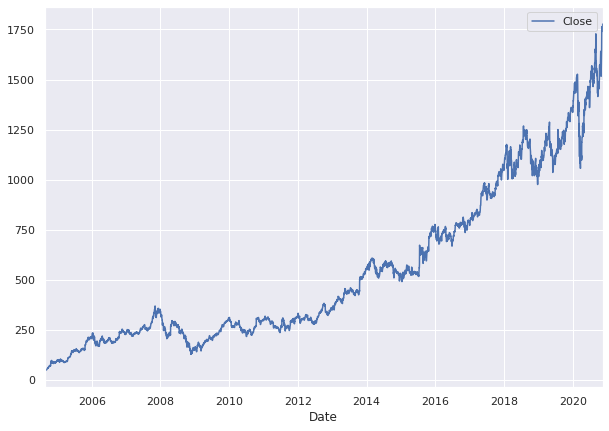

In [4]:
# affichage
df.plot();

In [5]:
# train et test sets
train = df[:"2020-08"]
test = df["2020-09":]

print(df.shape, train.shape, test.shape)
print(train.index[-5:])
print(test.index[:5])

(4237, 1) (4183, 1) (54, 1)
DatetimeIndex(['2020-08-25', '2020-08-26', '2020-08-27', '2020-08-28',
               '2020-08-31'],
              dtype='datetime64[ns]', name='Date', freq='B')
DatetimeIndex(['2020-09-01', '2020-09-02', '2020-09-03', '2020-09-04',
               '2020-09-07'],
              dtype='datetime64[ns]', name='Date', freq='B')


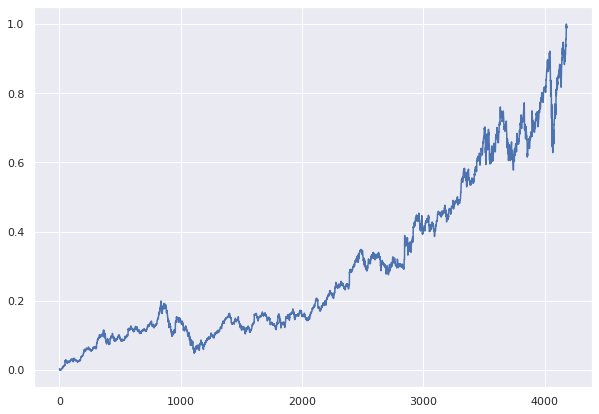

In [6]:
# Feature-scaling : normalisation min-max
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train = sc.fit_transform(train)
plt.plot(train);

In [7]:
# Création de la structure des données avec un nombre fixé n de timesteps et 1 output c'est à dire qu'on va prédire la valeur de l'action pour 1 jour à partir des n précédents
timesteps = 60 #on crée un paramètre pour pouvoir le modifier facilement par la suite
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    X_train.append(train[i-timesteps:i, 0])
    y_train.append(train[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape, y_train.shape)

(4123, 60) (4123,)


In [8]:
# Ajout d'une 3ème dimension à X_train
X_train = np.expand_dims(X_train, axis=2)
X_train.shape

(4123, 60, 1)

## **2. Construction du réseau**

1. Continuer de regarder un peu la doc `keras` sur les RNN pour savoir quelles couches utiliser
2. En reprenant toujours les mêmes étapes (initialisation, ajout de couches cachées, couche de sortie, paramètres d'entraînement, entraînement), construire un RNN comprenant plusieurs couches LSTM empilées.  
Ne pas oublier de gérer le sur-apprentissage s'il y en a...

Premier modèle RNN
```python
# Librairies
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Initialisation
model0 = Sequential()

# 1ère couche LSTM
model0.add(LSTM(units = 50, input_shape=(X_train.shape[1], X_train.shape[2])))

# Output
model0.add(Dense(units = 1))

# Paramètres d'entraînement
model0.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Entraînement
model0.fit(X_train, y_train, epochs = 15, batch_size = 32)
```

In [9]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Initialisation
model = Sequential()

# 1ère couche LSTM avec régularisation Dropout
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

# 2ème couche LSTM avec régularisation Dropout
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# 3ème couche LSTM avec régularisation Dropout
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# 4ème couche LSTM avec régularisation Dropout
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Output
model.add(Dense(units = 1))

# Paramètres d'entraînement
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Entraînement
model.fit(X_train, y_train, epochs = 20, batch_size = 32)

Epoch 1/20
129/129 [==============================] - 27s 207ms/step - loss: 0.0078
Epoch 2/20
129/129 [==============================] - 28s 214ms/step - loss: 0.0020
Epoch 3/20
129/129 [==============================] - 32s 244ms/step - loss: 0.0017
Epoch 4/20
129/129 [==============================] - 31s 243ms/step - loss: 0.0018
Epoch 5/20
129/129 [==============================] - 32s 247ms/step - loss: 0.0015
Epoch 6/20
129/129 [==============================] - 28s 218ms/step - loss: 0.0014
Epoch 7/20
129/129 [==============================] - 25s 191ms/step - loss: 0.0013
Epoch 8/20
129/129 [==============================] - 30s 234ms/step - loss: 0.0011
Epoch 9/20
129/129 [==============================] - 28s 218ms/step - loss: 0.0012
Epoch 10/20
129/129 [==============================] - 28s 220ms/step - loss: 0.0012
Epoch 11/20
129/129 [==============================] - 30s 236ms/step - loss: 0.0011
Epoch 12/20
129/129 [==============================] - 37s 290ms/step - lo

In [10]:
# Comme on dirait que ça n'a pas complétement convergé encore, on va continuer un peu l'entraînement
# Pour rappel on peut ajouter des epochs en repartant de l'état actuel du réseau
model.fit(X_train, y_train, epochs = 15, batch_size = 32)

Epoch 1/15
129/129 [==============================] - 37s 287ms/step - loss: 8.3367e-04
Epoch 2/15
129/129 [==============================] - 37s 288ms/step - loss: 7.0627e-04
Epoch 3/15
129/129 [==============================] - 29s 224ms/step - loss: 8.7884e-04
Epoch 4/15
129/129 [==============================] - 24s 187ms/step - loss: 8.1376e-04
Epoch 5/15
129/129 [==============================] - 26s 203ms/step - loss: 7.3765e-04
Epoch 6/15
129/129 [==============================] - 29s 222ms/step - loss: 6.7990e-04
Epoch 7/15
129/129 [==============================] - 25s 197ms/step - loss: 6.7314e-04
Epoch 8/15
129/129 [==============================] - 24s 186ms/step - loss: 7.4893e-04
Epoch 9/15
129/129 [==============================] - 25s 193ms/step - loss: 7.4221e-04
Epoch 10/15
129/129 [==============================] - 34s 264ms/step - loss: 6.6860e-04
Epoch 11/15
129/129 [==============================] - 36s 279ms/step - loss: 7.0840e-04
Epoch 12/15
129/129 [=========

## **3. Prédiction, évaluation et visualisation**

**Première approche :** une première méthode est de prédire chaque jour à partir des dernières vraies valeurs. Cela a du sens puisque notre modèle est construit pour ça : prédire la valeur de l'action à j+1 à partir d'un nombre de jours précédents fixés. En revanche cela veut dire qu'on utilise à chaque fois les vraies valeurs de l'échantillon test pour prédire la suivante. Pour essayer d'être plus clair :  
>- on a un modèle entraîné avec les données jusqu'au 31/08/2020 et on veut prédire les valeurs du 01/09/2020 au 13/11/2020
>- notre modèle est fait pour prédire un jour à partir des précédents, le 31/08 on va donc prédire le 01/09 à partir des données des jours précédents
>- ensuite, le lendemain, le 01/09, on va prédire le 02/09 en utilisant la vraie valeur du 01/09 qu'on aura observée depuis ainsi que les précédentes
>- ensuite, le lendemain, le 02/09, on va prédire le 03/09 en utilisant les vraies valeurs des 01/09 et 02/09 et les précédentes
>- etc...
>
> Ce qu'on peut reprocher à cette méthode c'est de ne pas utiliser les nouvelles infos dans la construction du modèle mais uniquement pour la prédiction. Ça a un petit côté paradoxal mais en même temps on a pas forcément envie de réentraîner notre modèle tous les jours avec juste une seule valeur en plus.
>
>1. Le premier travail va être de formater les inputs de test pour qu'ils soient au même format que ceux de l'entraînement du modèle. Il faut donc répéter les opérations qu'on a faites pour le train. Avec quelques modifications quand même. hésitez pas à prendre un papier un crayon si ça chauffe trop...
>>- définir un objet `inputs` qui contient toutes les valeurs dont vous aurez besoin (donc les données du test + les n dernières valeurs du train nécessaires à la prédiction des n premières valeurs du test). Vous pouvez pour ça utiliser certaines méthodes des objets datetime de pandas.
>>- une fois que c'est fait, il vous reste plus qu'à normaliser et reconstruire votre `X_test` de la même manière que votre `X_train`
>2. Évaluer les prédictions avec une ou plusieurs métriques adaptées
>3. Afficher les prédictions sur un beau graphique

In [11]:
inputs = df[pd.date_range(end='2020-08-31', periods=timesteps, freq='B')[0]:]
inputs.iloc[[0,1,timesteps-1,timesteps]]

,Close
Date,
2020-06-09,1456.160034
2020-06-10,1465.849976
2020-08-31,1634.180054
2020-09-01,1660.709961


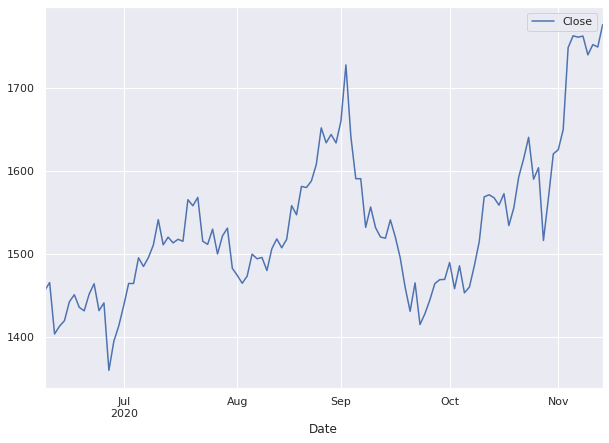

In [12]:
inputs.plot();

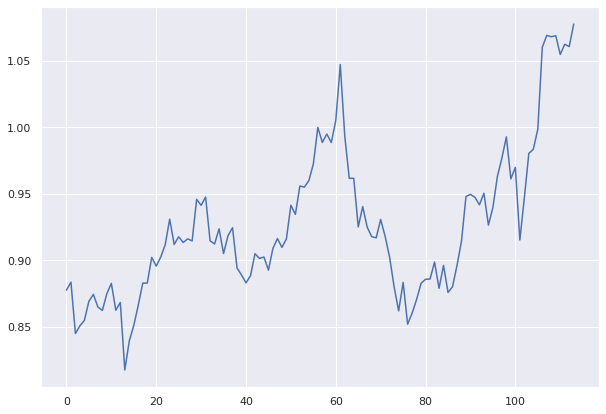

In [13]:
inputs = sc.transform(inputs)
plt.plot(inputs);

In [14]:
X_test = []
for i in range(timesteps, len(inputs)):
    X_test.append(inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.expand_dims(X_test, axis=2)
print(X_test.shape)

(54, 60, 1)


In [15]:
y_pred = model.predict(X_test)
y_pred = sc.inverse_transform(y_pred)

In [16]:
# Évaluation : RMSE et RMSE normalisé (ou relatif)
import math
from sklearn.metrics import mean_squared_error
y_real = test.values
RMSE = math.sqrt(mean_squared_error(y_real, y_pred))
nRMSE = RMSE/np.mean(y_real)
RMSE, nRMSE

(59.952009976113516, 0.03815703604897104)

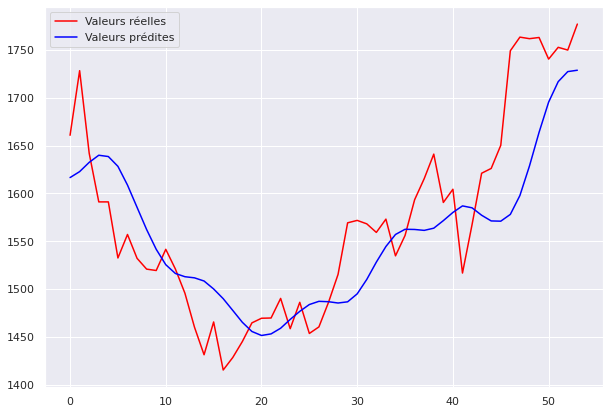

In [17]:
# Visualisation des résultats
plt.plot(y_real, color = 'red', label = 'Valeurs réelles')
plt.plot(y_pred, color = 'blue', label = 'Valeurs prédites')
plt.legend()
plt.show()

**Deuxième approche :** la deuxième possibilité consiste à prédire toutes la période de test à partir des infos au 31/08/2020. Cela pourrait avoir du sens si on veut savoir comment va évoluer la tendance à moyen terme (ou en tout cas à plus que j+1).
>- on a un modèle entraîné avec les données jusqu'au 31/08/2020 et on veut prédire les valeurs du 01/09/2020 au 13/11/2020
>- notre modèle est fait pour prédire un jour à partir des précédents, le 31/08 on va donc prédire le 01/09 à partir des données des jours précédents
>- puis, toujours le 31/08, on va prédire le 02/09 en utilisant la valeur prédite du 01/09 ainsi que les précédentes
>- puis, toujours le 31/08, on va prédire le 03/09 en utilisant les valeurs prédites des 01/09 et 02/09 ainsi que les précédentes
>- etc...
>
> Le modèle qu'on a construit est prévu pour ne prédire qu'à un jour donc on réutilise la prédiction comme input pour la prédiction du jour suivant. Le problème est qu'on multiplie ainsi les erreurs qui s'accumule un jour après l'autre. Cette méthode ne sera donc a priori pas très convaincante ou en tout cas pas sur une longue période...mais on va le faire quand même !
>
> Une autre approche, à tester pour en comparer l'efficacité mais certainement meilleure, serait de construire un modèle qui prédit plusieurs jours à partir des précédents.
>
>1. On va de nouveau formater les inputs mais différement bien sûr.
>>- définir un objet `inputs` qui contient toutes les valeurs les n dernières valeurs du train nécessaires à la prédiction
>>- faire la prédiction pour le 1er jour
>>- ajouter cette prédiction dans votre objet `inputs` et supprimer la 1ère valeur dont on aura plus besoin
>>- faire la prédiciton du second jour puis l'insérer dans votre `inputs`
>>- etc jusqu'à avoir prédit toutes les valeurs jusqu'au 13/11
>2. Évaluer et afficher les prédictions

In [18]:
inputs = df[pd.date_range(end='2020-08-31', periods=timesteps, freq='B')[0]:'2020-08-31']
inputs.iloc[[0,1,-1]]

,Close
Date,
2020-06-09,1456.160034
2020-06-10,1465.849976
2020-08-31,1634.180054


In [19]:
inputs = np.expand_dims(sc.transform(inputs), axis=0)
inputs.shape

(1, 60, 1)

In [20]:
y_pred = []
for i in range(len(test)):
    prediction = model.predict(inputs)[0,0]
    y_pred.append(prediction)
    inputs[0,0:timesteps-1,0] = inputs[0,1:timesteps,0]
    inputs[0,timesteps-1,0] = prediction
y_pred = np.array(y_pred).reshape(-1,1)
y_pred = sc.inverse_transform(y_pred)

In [21]:
RMSE = math.sqrt(mean_squared_error(y_real, y_pred))
nRMSE = RMSE/np.mean(y_real)
RMSE, nRMSE

(109.10124970210735, 0.06943854458807543)

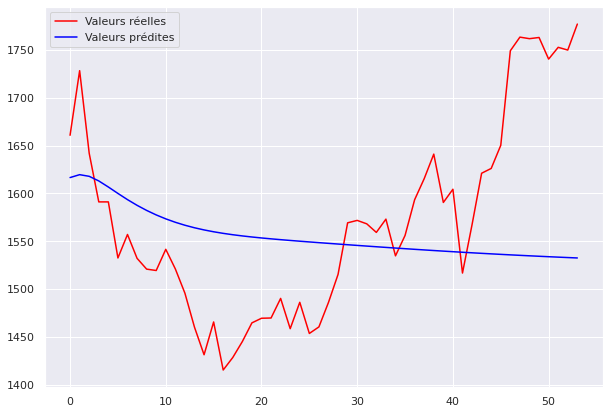

In [22]:
plt.plot(y_real, color = 'red', label = 'Valeurs réelles')
plt.plot(y_pred, color = 'blue', label = 'Valeurs prédites')
plt.legend()
plt.show()

## **4. Amélioration du modèle**

En revenant sur la première approche, essayer d'amélorier le modèle.

Quelques pistes qui peuvent évidemment être combinées mais tout ça étant coûteux en temps, vous ne pourrez pas tout tester :
- Plus de données, quand c'est possible
- Augmenter le nombre de "timesteps" pour regarder plus loin dans le passé
- Ajouter d'autres variables : par exemple on pourrait ajouter des actions d'autres entreprises dont l'action pourrait être corrélée à celle de Google
- Compléxifier le réseau : plus de couches/neurones
- Ajustement des hyperparamètres

## **5. Ajout de variables supplémentaires**

Comme évoqué, on pourrait vouloir ajouter d'autres variables pour améliorer les performances de notre modéle. Dans cette partie, il s'agit de mettre en oeuvre un RNN avec plusieurs variables. Sans aller chercher l'action d'une autre entreprise des GAFA par exemple, on va se contenter pour simplifier ici d'uitiliser les autres variables disponibles dans le dataset (Open, High et Low).

1. À vous de modifier votre code pour prendre en compte dans votre modèle les 4 informations Open, High, Low et Close.
2. Comparer les prédictions obtenues (et les temps d'exécution !)

In [23]:
df = pd.read_csv('data/GOOG.csv', usecols=['Date','Open', 'High', 'Low', 'Close'], index_col='Date', parse_dates=True)
df = df.asfreq('B', method="ffill")
df.tail()

,Open,High,Low,Close
Date,,,,
2020-11-09,1790.900024,1818.060059,1760.020020,1763.000000
2020-11-10,1731.089966,1763.000000,1717.300049,1740.390015
2020-11-11,1750.000000,1764.219971,1747.364990,1752.709961
2020-11-12,1747.630005,1768.270020,1745.599976,1749.839966
2020-11-13,1757.630005,1781.040039,1744.550049,1777.020020


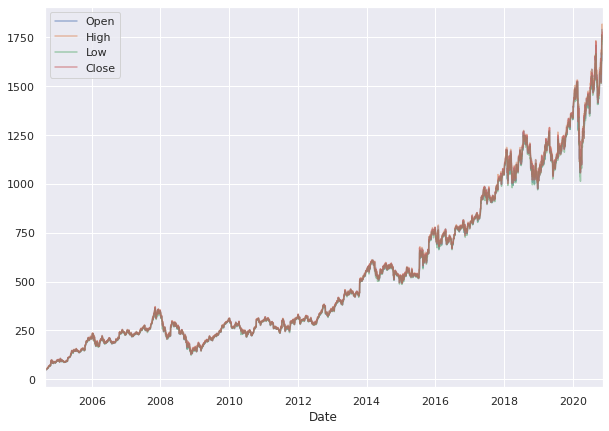

In [24]:
df.plot(alpha=0.5);

In [25]:
# train et test sets
train = df[:"2020-08"]
test = df["2020-09":]
print(df.shape, train.shape, test.shape)

(4237, 4) (4183, 4) (54, 4)


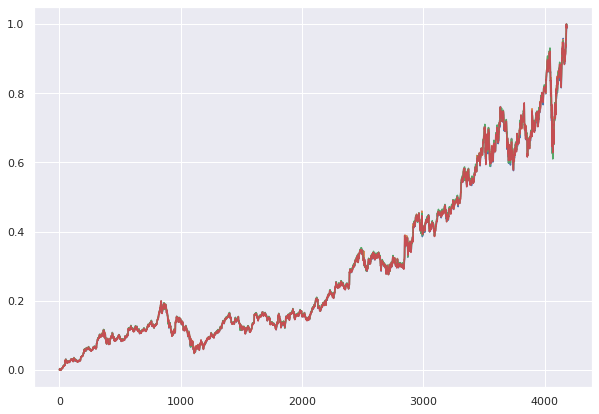

In [26]:
# Feature-scaling : normalisation min-max
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train = sc.fit_transform(train)
plt.plot(train);

In [27]:
# Création de la structure des données avec un nombre fixé n de timesteps et 1 output c'est à dire qu'on va prédire la valeur de l'action pour 1 jour à partir des n précédents
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    y_train.append(train[i, 3])
    tmp = []
    for day in range(timesteps, 0, -1):
        tmp.append(train[i-day])
    X_train.append(np.array(tmp))
    
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape, y_train.shape)

# à tester : 
#for i in range(timesteps, train.shape[0]):
#    X_train.append(train[i-timesteps:i])
#    y_train.append(train[i, 3])

(4123, 60, 4) (4123,)


In [28]:
# Modèle RNN
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train, y_train, epochs = 35, batch_size = 32)

Epoch 1/35
129/129 [==============================] - 34s 263ms/step - loss: 0.0072
Epoch 2/35
129/129 [==============================] - 36s 277ms/step - loss: 0.0023
Epoch 3/35
129/129 [==============================] - 34s 267ms/step - loss: 0.0019
Epoch 4/35
129/129 [==============================] - 32s 246ms/step - loss: 0.0018
Epoch 5/35
129/129 [==============================] - 35s 274ms/step - loss: 0.0015
Epoch 6/35
129/129 [==============================] - 31s 240ms/step - loss: 0.0015
Epoch 7/35
129/129 [==============================] - 31s 241ms/step - loss: 0.0014
Epoch 8/35
129/129 [==============================] - 41s 318ms/step - loss: 0.0014
Epoch 9/35
129/129 [==============================] - 31s 241ms/step - loss: 0.0012
Epoch 10/35
129/129 [==============================] - 26s 204ms/step - loss: 0.0013
Epoch 11/35
129/129 [==============================] - 28s 216ms/step - loss: 0.0012
Epoch 12/35
129/129 [==============================] - 32s 245ms/step - lo

In [29]:
inputs = df[pd.date_range(end='2020-08-31', periods=timesteps, freq='B')[0]:]
inputs.iloc[[0,1,timesteps-1,timesteps]]

,Open,High,Low,Close
Date,,,,
2020-06-09,1445.359985,1468.000000,1443.209961,1456.160034
2020-06-10,1459.540039,1474.259033,1456.270020,1465.849976
2020-08-31,1647.890015,1647.964966,1630.310059,1634.180054
2020-09-01,1636.630005,1665.729980,1632.219971,1660.709961


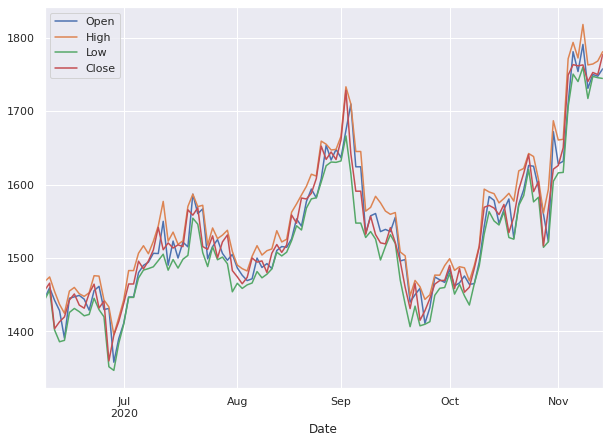

In [30]:
inputs.plot();

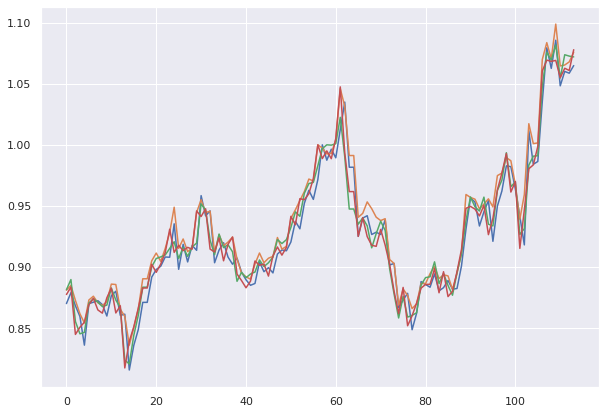

In [31]:
inputs = sc.transform(inputs)
plt.plot(inputs);

In [32]:
X_test = []
for i in range(timesteps, len(inputs)):
    tmp = []
    for day in range(timesteps, 0, -1):
        tmp.append(inputs[i-day])
    X_test.append(np.array(tmp))

X_test = np.array(X_test)
print(X_test.shape)

(54, 60, 4)


In [33]:
y_pred = model.predict(X_test)

In [34]:
# Le sc a été fitté sur une matrice a 4 colonnes donc pour revenir aux vraies valeurs grace à inverse_transform il faut :
# - soit créer une matrice intermédiaire à 4 colonnes avec y_pred en 4ème colonne (colonne Close), faire l'inverse_transform puis récupérer les valeurs
# - soit fitter un nouveau transformer uniquement sur la colonne Close du train et faire l'inverse_transform sur y_pred
mat = np.zeros((y_pred.shape[0], 4))
mat[:, 3] = y_pred[:,0]
mat = sc.inverse_transform(mat)
y_pred = mat[:,3]

In [35]:
# Évaluation : RMSE et RMSE normalisé (ou relatif)
import math
from sklearn.metrics import mean_squared_error
y_real = test.Close.values
RMSE = math.sqrt(mean_squared_error(y_real, y_pred))
nRMSE = RMSE/np.mean(y_real)
RMSE, nRMSE

(79.66595209444462, 0.05070416500054739)

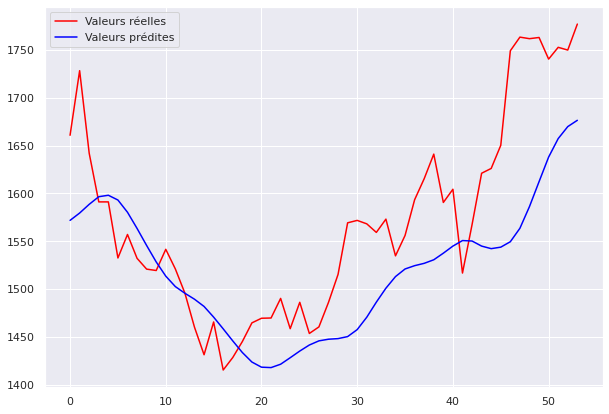

In [36]:
# Visualisation des résultats
plt.plot(y_real, color = 'red', label = 'Valeurs réelles')
plt.plot(y_pred, color = 'blue', label = 'Valeurs prédites')
plt.legend()
plt.show()